In [57]:
import requests
import pandas as pd
import numpy as np
import argparse
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch

In [3]:
API_BASE_URL='https://clinicaltrials.gov/api/query'
EXAMPLE_DRUG = 'gabapentin'

## Make Data into Tables

In [4]:
def get_studies_by_expression(expression):
    r = requests.get(API_BASE_URL + '/full_studies?expr={expr}&min_rnk=1&max_rnk=99&fmt=json'
                     .format(expr=expression))
    return r.json()


def get_conditions_for_drug(drug):
    r = requests.get(API_BASE_URL + '/field_values?expr={drug}&field=ConditionAncestorTerm&fmt=json'
                     .format(drug=drug))
    
    return r.json()


def get_all_studies(expr, results=True):
    og_length = 99
    studies = []
    count = 0
    while (og_length >= 99):
        r = requests.get(API_BASE_URL + '/full_studies?expr={expr}&min_rnk={min_rank}&max_rnk={max_rank}&fmt=json'
                         .format(expr=expr, min_rank=count*99 + 1, max_rank=(count*99+1)+98))
        og_length = len(r.json()['FullStudiesResponse'].get('FullStudies', []))
        new_studies = r.json()['FullStudiesResponse'].get('FullStudies', [{'Study': []}])
        studies += list(filter(lambda x: 'ResultsSection' in x['Study'] and 'OutcomeMeasuresModule' in x['Study']['ResultsSection'], new_studies))
        count+=1
        
    return studies

studies = get_all_studies(EXAMPLE_DRUG)

In [5]:
def create_studies_table(studies, drug):
    buffer = {
        'study_id': [], 'name': [], 'drug': [], 'conditions': [], 
        'verified_date': [], 'responsible_party': [], 'type': [], 'description': [],
        'interventions': [], 'purpose': [], 'intervention_type': [], 'mesh_terms': []
              
         }
    for i, study in enumerate(studies):


        buffer['drug'].append(drug)
        try:
            buffer['study_id'].append(study['Study']['ProtocolSection']['IdentificationModule']['NCTId'])
        except KeyError as e:
            buffer['study_id'].append('NA')

        try:
            buffer['name'].append(study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
        except KeyError as e:
            buffer['name'].append('NA')

        try:
            buffer['verified_date'].append(study['Study']['ProtocolSection']['StatusModule']['StatusVerifiedDate'])
        except KeryError as e:
            buffer['verified_date'].append('NA')

        try:
            buffer['responsible_party'].append(study['Study']['ProtocolSection']['SponsorCollaboratorsModule']['ResponsibleParty'])
        except KeyError as e:
            buffer['responsible_party'].append('NA')

        try: 
            buffer['conditions'].append(study['Study']['ProtocolSection']['ConditionsModule']['ConditionList']['Condition'])
        except KeyError as e:
            buffer['conditions'].append('NA')

        try:
            buffer['type'].append(study['Study']['ProtocolSection']['DesignModule']['StudyType'])
        except KeyError as e:
            buffer['type'].append('NA')
        
        buffer['purpose'].append(study['Study']['ProtocolSection']['DesignModule']['DesignInfo'].get('DesignPrimaryPurpose', 'NA'))
        buffer['intervention_type'].append(study['Study']['ProtocolSection']['DesignModule']['DesignInfo'].get('DesignInterventionModel', 'NA'))
        
        try:
            buffer['mesh_terms'].append([x.get('ConditionMeshTerm', 'NA') for x in study['Study']['DerivedSection']['ConditionBrowseModule']['ConditionMeshList']['ConditionMesh']])
        except KeyError as e:
            buffer['mesh_terms'].append([])
            
        try:
            buffer['description'].append(study['Study']['ProtocolSection']['DescriptionModule']['DetailedDescription'])
        except KeyError as e:
            buffer['description'].append('NA')
            
        try: 
            buffer['interventions'].append([x.get('InterventionMeshTerm', 'NA') for x in study['Study']['DerivedSection']['InterventionBrowseModule']['InterventionMeshList']['InterventionMesh']])
        except KeyError as e:
            buffer['interventions'].append([])
    
    return buffer


def create_groups_table(studies): # The groups in the baseline -> this might end up badly 
    groups_df = { 
        'name': [],
        'study_id': [],
        'id': [],
        'description': [],
        'participants': [],
        'maybe_arm_type': []
    }
    parts = []
    for study in studies:
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        groups = []
        denoms = []
        try: 
            groups = study['Study']['ResultsSection']['BaselineCharacteristicsModule']['BaselineGroupList']['BaselineGroup']
        except KeyError as e:
            groups = []
            
        # Get the type of groups from arm 
        arms = study['Study']['ProtocolSection']['ArmsInterventionsModule']['ArmGroupList'].get('ArmGroup', [])
        types = []
        for arm in arms:
            label = arm.get('ArmGroupLabel', None)
            armType = arm.get('ArmGroupType', None)
            types.append(armType)
            
        for i, group in enumerate(groups):
            groups_df['name'].append(group.get('BaselineGroupTitle', 'NA'))
            groups_df['study_id'].append(study_id)
            groups_df['id'].append(group.get('BaselineGroupId', 'NA'))
            groups_df['description'].append(group.get('BaselineGroupDescription', 'NA'))
            groups_df['maybe_arm_type'].append(types[i] if i<len(types)else 'NA')
                
        try:
            denoms = study['Study']['ResultsSection']['BaselineCharacteristicsModule']['BaselineDenomList']['BaselineDenom']
        except KeyError as e:
            denoms = []
            
        participants = list(filter(lambda x: x.get('BaselineDenomUnits', 'NA') == 'Participants', denoms))
        for participant in participants[0]['BaselineDenomCountList']['BaselineDenomCount']:
            groups_df['participants'].append(int(participant['BaselineDenomCountValue']))
            
    return groups_df, parts


def get_outcome_modules(studies):
    outcome_modules = []
    for study in studies:
        if 'OutcomeMeasuresModule' in study['Study']['ResultsSection']:
            outcome_modules.append(study['Study']['ResultsSection']['OutcomeMeasuresModule'])
            continue 
        print('No Results: ', study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
        
    return outcome_modules


def create_measures_table(studies):
    outcome_modules = get_outcome_modules(studies)
    df = {
        'study_id': [],
        'measure': [],
        'type': [],
        'description': [],
        'dispersion_param': [],
        'measure_param': [],
        'units': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            df['type'].append(measure.get('OutcomeMeasureType', 'NA'))
            df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
            df['description'].append(measure.get('OutcomeMeasureDescription', 'NA'))
            df['measure_param'].append(measure.get('OutcomeMeasureParamType', 'NA'))
            df['dispersion_param'].append(measure.get('OutcomeMeasureDispersionType', 'NA'))
            df['units'].append(measure.get('OutcomeMeasureUnitOfMeasure', 'NA'))
            df['study_id'].append(study_id)
            
    return df 


def create_outcomes_table(studies):
    outcome_modules = get_outcome_modules(studies)
    admin_df = {
        'study_id': [],
        'group_id': [],
        'measure': [],
        'title': [],
        'description': [],
    }
    
    outcome_df = {
        'study_id': [],
        'group_id': [],
        'measure': [],
        'title': [],
        'value': [],
        'dispersion': [],
        'upper': [],
        'lower': [],
        'participants': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            try:
                overall_group_to_no = {}
                for denom in measure.get('OutcomeDenomList', {'OutcomeDenom': []})['OutcomeDenom']:
                    if denom.get('OutcomeDenomUnits', 'NA') == 'Participants':
                        for count in denom.get('OutcomeDenomCountList', {'OutcomeDenomCount': []})['OutcomeDenomCount']:
                            overall_group_to_no[count['OutcomeDenomCountGroupId']] = count['OutcomeDenomCountValue']
                                
                for admin in measure.get('OutcomeGroupList', {'OutcomeGroup': []})['OutcomeGroup']:
                    admin_df['study_id'].append(study_id)
                    admin_df['group_id'].append(admin.get('OutcomeGroupId', 'NA'))
                    admin_df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
                    admin_df['title'].append(admin.get('OutcomeGroupTitle', 'NA'))
                    admin_df['description'].append(admin.get('OutcomeGroupDescription', 'NA'))
                    
                # Sometimes the participants are just listed one time before all the others - not just in the class
                for group in measure.get('OutcomeClassList', {'OutcomeClass': []})['OutcomeClass']:
    
                    group_to_no = {}
                    for denom in group.get('OutcomeClassDenomList', {'OutcomeClassDenom': []})['OutcomeClassDenom']:
                        for count in denom.get('OutcomeClassDenomCountList', {'OutcomeClassDenomCount': []})['OutcomeClassDenomCount']:
                            group_to_no[count['OutcomeClassDenomCountGroupId']] = count['OutcomeClassDenomCountValue']

                    for cat in group.get('OutcomeCategoryList', {'OutcomeCategory': []})['OutcomeCategory']:
                        for outcome in cat['OutcomeMeasurementList']['OutcomeMeasurement']:
                            outcome_df['study_id'].append(study_id)
                            outcome_df['group_id'].append(outcome.get('OutcomeMeasurementGroupId', 'NA'))
                            outcome_df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
                            outcome_df['value'].append(outcome.get('OutcomeMeasurementValue', 'NA'))
                            outcome_df['dispersion'].append(outcome.get('OutcomeMeasurementSpread', 'NA'))
                            outcome_df['upper'].append(outcome.get('OutcomeMeasurementUpperLimit', 'NA'))
                            outcome_df['lower'].append(outcome.get('OutcomeMeasurementLowerLimit', 'NA'))
                            outcome_df['participants'].append(group_to_no.get(outcome.get('OutcomeMeasurementGroupId', 'NA'), None) or overall_group_to_no.get(outcome.get('OutcomeMeasurementGroupId', 'NA'), 'NA'))
                            outcome_df['title'].append(group.get('OutcomeClassTitle', 'NA'))
                        
                    
            except KeyError as e:
                print(e)
                continue
                
    return (admin_df, outcome_df)


def create_analytics_table(studies):
    outcome_modules = get_outcome_modules(studies)
    df = {
        'study_id': [],
        'measure': [],
        'groups': [],
        'description': [], # may or may not be the outcome title
        'method': [],
        'param_type': [],
        'fromStudy': [],
        'pval': [],
        'group_titles': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            group_to_title = {}
            for group in measure.get('OutcomeGroupList', {'OutcomeGroup': []})['OutcomeGroup']:
                if group['OutcomeGroupId'] not in group_to_title:
                    group_to_title[group['OutcomeGroupId']] = 'NA'
                group_to_title[group['OutcomeGroupId']] = group.get('OutcomeGroupTitle', 'NA')
                    
            measure_title = measure.get('OutcomeMeasureTitle', 'NA')
            for stat in measure.get('OutcomeAnalysisList', {'OutcomeAnalysis': []})['OutcomeAnalysis']:
                df['study_id'].append(study_id)
                df['measure'].append(measure_title)
                df['groups'].append(stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId'])
                df['description'].append(stat.get('OutcomeAnalysisGroupDescription', 'NA'))
                df['method'].append(stat.get('OutcomeAnalysisStatisticalMethod', 'NA'))
                df['param_type'].append(stat.get('OutcomeAnalysisParamType', 'NA'))
                df['fromStudy'].append(True)
                df['pval'].append(stat.get('OutcomeAnalysisPValue', 'NA'))
                df['group_titles'].append(dict([(g, group_to_title.get(g, 'NA')) for g in stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId']]))
    return df


def create_effects_table(studies, drug):
    df = {
        'drug': [],
        'study_id': [],
        'group_id': [],
        'effect_name': [],
        'type': [], #Serious or other
        'organ_system': [],
        'assesment': [],
        'no_effected': [],
        'collection_threshold': []
    }
    for i, study in enumerate(studies):
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        adverse_module = study['Study']['ResultsSection'].get('AdverseEventsModule', {}) #Small risk here
        for event in adverse_module.get('OtherEventList', {'OtherEvent': []})['OtherEvent']:
            for stat in event.get('OtherEventStatsList', {'OtherEventStats': []})['OtherEventStats']:
                df['drug'].append(drug)
                df['study_id'].append(study_id)
                df['group_id'].append(stat.get('OtherEventStatsGroupId', 'NA'))
                df['effect_name'].append(event.get('OtherEventTerm', 'NA'))
                df['type'].append('other')
                df['organ_system'].append(event.get('OtherEventOrganSystem', 'NA'))
                df['assesment'].append(event.get('OtherEventAssessmentType', 'NA'))
                df['no_effected'].append(float(stat.get('OtherEventStatsNumAffected', 0)) or float(stat.get('OtherEventStatsNumEvents', 0)))
                df['collection_threshold'].append(float(adverse_module.get('EventsFrequencyThreshold', -1)))
    return df

def create_analytics_table(studies):
    outcome_modules = get_outcome_modules(studies)
    df = {
        'study_id': [],
        'measure': [],
        'groups': [],
        'description': [], # may or may not be the outcome title
        'method': [],
        'param_type': [],
        'fromStudy': [],
        'pval': [],
        'group_titles': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            group_to_title = {}
            for group in measure.get('OutcomeGroupList', {'OutcomeGroup': []})['OutcomeGroup']:
                if group['OutcomeGroupId'] not in group_to_title:
                    group_to_title[group['OutcomeGroupId']] = 'NA'
                group_to_title[group['OutcomeGroupId']] = group.get('OutcomeGroupTitle', 'NA')
                    
            measure_title = measure.get('OutcomeMeasureTitle', 'NA')
            for stat in measure.get('OutcomeAnalysisList', {'OutcomeAnalysis': []})['OutcomeAnalysis']:
                df['study_id'].append(study_id)
                df['measure'].append(measure_title)
                df['groups'].append(stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId'])
                df['description'].append(stat.get('OutcomeAnalysisGroupDescription', 'NA'))
                df['method'].append(stat.get('OutcomeAnalysisStatisticalMethod', 'NA'))
                df['param_type'].append(stat.get('OutcomeAnalysisParamType', 'NA'))
                df['fromStudy'].append(True)
                df['pval'].append(stat.get('OutcomeAnalysisPValue', 'NA'))
                df['group_titles'].append(dict([(g, group_to_title.get(g, 'NA')) for g in stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId']]))
    return df


In [6]:
def create_all_tables(drug):
    studies_table = pd.DataFrame.from_dict(create_studies_table(studies, drug))
    groups_table = pd.DataFrame.from_dict(create_groups_table(studies)[0])
    measures_table = pd.DataFrame.from_dict(create_measures_table(studies))
    admin_df, outcome_df = create_outcomes_table(studies)
    admins_table = pd.DataFrame.from_dict(admin_df)
    outcomes_table = pd.DataFrame.from_dict(outcome_df)
    analytics = pd.DataFrame.from_dict(create_analytics_table(studies))

    return studies_table, groups_table, measures_table, admin_df, outcome_df, admins_table, outcomes_table, analytics

studies_table, groups_table, measures_table, admin_table, outcome_table, admins_table, outcomes_table, analytics_table = create_all_tables(EXAMPLE_DRUG)
admin_table = pd.DataFrame.from_dict(admin_table)

## Labeling
- Let's get a small table to label the important parts of the data

In [ ]:
# Need to label dosage and what measures do
admin_table

## Word Embeddings
- Creating our own embeddings using pytorch and the vocabulary

In [78]:
# Get all words:
# We need to split up th different sources, maybe even split the sentences within the sources.
corpus = []
# Studies table first
for description in studies_table['description']:
    corpus.append(description)
for name in studies_table['name']:
    corpus.append(name)

# Groups table
for description in groups_table['description']:
    corpus.append(description)

# Measures table
for name in measures_table['measure']:
    corpus.append(name)
for description in groups_table['description']:
    corpus.append(description)

for title in admin_table['title']:
    corpus.append(title)
    
# Remove all dupes and make a word_to_idx
from nltk import word_tokenize, sent_tokenize

for i, item in enumerate(corpus):
    corpus[i] = sent_tokenize(item)
    
#Flatten it
corpus = [item for sublist in corpus for item in sublist]

for i, sentence in enumerate(corpus):
    corpus[i] = word_tokenize(sentence)

In [79]:
vocabulary = []
for sentence in corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

In [80]:
vocabulary_size

5757

In [81]:
window_size = 2
idx_pairs = []
for sentence in corpus:
    indices = [word2idx[word] for word in sentence]
    for center_word_pos in range(len(indices)):
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs)

In [83]:
from torch.autograd import Variable
import torch.functional as F
import torch.nn.functional as F

def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x


embedding_dims = 5
W1 = Variable(torch.randn(embedding_dims, vocabulary_size).float(), requires_grad=True)
W2 = Variable(torch.randn(vocabulary_size, embedding_dims).float(), requires_grad=True)
num_epochs = 100
learning_rate = 0.001

for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:
        x = Variable(get_input_layer(data)).float()
        y_true = Variable(torch.from_numpy(np.array([target])).long())

        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.item()
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    
    print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')

Loss at epo 0: 9.916266965752927
Loss at epo 1: 9.31459028504749
Loss at epo 2: 8.911607049649959
Loss at epo 3: 8.448488170568657
Loss at epo 4: 8.072350822266312
Loss at epo 5: 7.795666459214385
Loss at epo 6: 7.586963564499004
Loss at epo 7: 7.4209513433337095
Loss at epo 8: 7.28395445143183
Loss at epo 9: 7.168759074597658
Loss at epo 10: 7.0708132757735775
Loss at epo 11: 6.986700269175948
Loss at epo 12: 6.913631843859197
Loss at epo 13: 6.849426179948657
Loss at epo 14: 6.792365624030331
Loss at epo 15: 6.741140774575376
Loss at epo 16: 6.694752104496162
Loss at epo 17: 6.652419498373456
Loss at epo 18: 6.613526370138668
Loss at epo 19: 6.577579939961603
Loss at epo 20: 6.544186405363211
Loss at epo 21: 6.5130299991077685
Loss at epo 22: 6.483856353770353
Loss at epo 23: 6.456462122974681
Loss at epo 24: 6.430675818517
Loss at epo 25: 6.406349136696928
Loss at epo 26: 6.383350204619616
Loss at epo 27: 6.361569366682629
Loss at epo 28: 6.3409069222272185
Loss at epo 29: 6.3212772

KeyboardInterrupt: 

In [84]:
# torch.save(W1, 'w1.pt')
# torch.save(W2, 'w2.pt')

In [104]:
# Load weights
word2vec1 = torch.load('w1.pt') # [embed_dim, vocab_size]
word2vec2 = torch.load('w2.pt') # [vocab_size, embed_dim]

In [105]:
def get_word_embed(word):
    word_idx = word2idx[word]
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    
    return torch.matmul(word2vec1, x)


### Testing
- Let's do a projection and see how our word2vec clustered

In [87]:
from sklearn.manifold import TSNE

weights_arr = word2vec1.detach().numpy()
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 200)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(weights_arr.T[:400])

/Users/porterhunley/anaconda3/envs/nlp/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


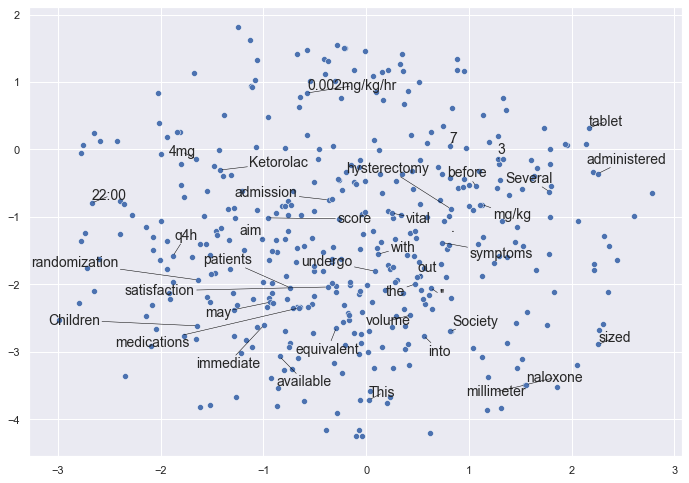

In [107]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 1)

from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], idx2word[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.7, force_text = 0.7, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

## Group Types
- Labelign the types of each group such that we can aggregate them later to run some analysis. Group types can consist of controls, single drug, multi-drug

### Name Clustering
- Let's see how far name clustering can get to construct these groups

In [115]:
def embed_str_col(col):
    return col.apply(lambda x: [get_word_embed(y) for y in x])
    

In [130]:
# first we filter out studies that arent liek this
interventional_ids = studies_table[studies_table['type'] == 'Interventional']['study_id'].to_list()
interventional_admins = admin_table[admin_table['study_id'].apply(lambda x: x in interventional_ids)]

In [133]:
# average the vectors together to form the document vector 
# Need to add in the description to the mix
# remove the stop words from both as well

from nltk.tokenize import word_tokenize

token_titles = interventional_admins['title'].apply(word_tokenize)
token_desc = interventional_admins['description'].apply(word_tokenize)

toeknized_group = token_titles + token_desc

In [ ]:
from nltk.tokenize import word_tokenize, sent_tokenize
# Get the embeddings and use the SIF method

def weight_words(docs):
    # count the frequency of the words
    freq = {}
    for doc in docs:
        tokens = word_tokenize(doc)
        for token in tokens:
            if token not in freq:
                freq[token] = 0
            freq[token] += 1
        
    

In [129]:
interventional_admins.head()

,study_id,group_id,measure,title,description,token_titles,token_desc
0,NCT01675960,OG000,Symptom Relief for Chronic Irritability in Neu...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,[Gabapentin],"[Neurotin, Gabapentin, :, The, active, drug, i..."
1,NCT01675960,OG001,Symptom Relief for Chronic Irritability in Neu...,Placebo,Glycerin based clear solution that is flavored...,[Placebo],"[Glycerin, based, clear, solution, that, is, f..."
2,NCT01675960,OG000,Prevalence of Associated Gastrointestinal and ...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,[Gabapentin],"[Neurotin, Gabapentin, :, The, active, drug, i..."
3,NCT01675960,OG001,Prevalence of Associated Gastrointestinal and ...,Placebo,Glycerin based clear solution that is flavored...,[Placebo],"[Glycerin, based, clear, solution, that, is, f..."
4,NCT02359110,OG000,NRS (Numerical Rating Scale),Gabapentin,Patients will receive Gabapentin 300mg tab les...,[Gabapentin],"[Patients, will, receive, Gabapentin, 300mg, t..."
